In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [45]:
# 데이터 로드
df_gap = pd.read_csv('new_data/(사용액)decoupling_results.csv', encoding='utf-8-sig')
df_m2_raw = pd.read_csv('전처리/전처리_M2.csv', encoding='utf-8')

In [46]:
# 디커플링 데이터 전처리
if 'date' not in df_gap.columns:
    df_gap = df_gap.reset_index().rename(columns={'index': 'date'})

df_gap['date'] = pd.to_datetime(df_gap['date'])
df_gap['date'] = df_gap['date'].apply(lambda x: x.replace(day=1))
df_gap = df_gap.set_index('date').sort_index()

In [47]:
# M2 데이터 전처리 (업로드하신 csv 구조에 맞게 수정됨)
df_m2 = df_m2_raw.copy()
df_m2['date'] = pd.to_datetime(df_m2['date'])
df_m2['date'] = df_m2['date'].apply(lambda x: x.replace(day=1))
df_m2 = df_m2.set_index('date').sort_index()

# M2 전년동기대비 증가율 계산 (로그 차분)
df_m2['m2_growth'] = np.log(df_m2['M2']).diff(12)

In [48]:
# 데이터 병합
# 두 데이터가 겹치는 기간만 추출
df = df_gap[['gap', 'fin_index']].join(df_m2[['m2_growth']], how='inner').dropna()
print(f"데이터 병합 완료: 총 {len(df)}개 행이 분석에 사용됩니다.")

데이터 병합 완료: 총 251개 행이 분석에 사용됩니다.


In [49]:
# [가설 1 검증] 시차 상관관계 분석
print("\n--- [H1] 유동성 선반영 가설 검증 ---")
for lag in [0, 1, 3, 6]:
    # 임시 데이터프레임 생성
    temp = df[['m2_growth', 'gap']].copy()
    temp['m2_shifted'] = temp['m2_growth'].shift(lag)
    temp = temp.dropna()
    
    if len(temp) < 2:
        print(f"Lag {lag}: 데이터 부족")
        continue
        
    corr, p = pearsonr(temp['m2_shifted'], temp['gap'])
    print(f"Lag {lag} month(s): 상관계수 = {corr:.4f} (p-value={p:.4f})")


--- [H1] 유동성 선반영 가설 검증 ---
Lag 0 month(s): 상관계수 = -0.3608 (p-value=0.0000)
Lag 1 month(s): 상관계수 = -0.3416 (p-value=0.0000)
Lag 3 month(s): 상관계수 = -0.3108 (p-value=0.0000)
Lag 6 month(s): 상관계수 = -0.2357 (p-value=0.0002)


In [50]:
# [가설 2 검증] 비대칭적 유입 (금융지수 vs M2)
median_val = df['m2_growth'].median()
high_liq = df[df['m2_growth'] > median_val]
low_liq = df[df['m2_growth'] <= median_val]

# 상관계수(corr)와 유의확률(p-value)을 모두 구합니다
corr_high, p_high = pearsonr(high_liq['fin_index'], high_liq['m2_growth'])
corr_low, p_low = pearsonr(low_liq['fin_index'], low_liq['m2_growth'])

print(f"\n--- [H2] 비대칭적 유입 가설 검정 결과 ---")
print(f"고유동성 구간 (N={len(high_liq)}): 상관계수 = {corr_high:.4f}, p-value = {p_high:.4f}")
print(f"저유동성 구간 (N={len(low_liq)}): 상관계수 = {corr_low:.4f}, p-value = {p_low:.4f}")


--- [H2] 비대칭적 유입 가설 검정 결과 ---
고유동성 구간 (N=125): 상관계수 = -0.4567, p-value = 0.0000
저유동성 구간 (N=126): 상관계수 = 0.0745, p-value = 0.4073


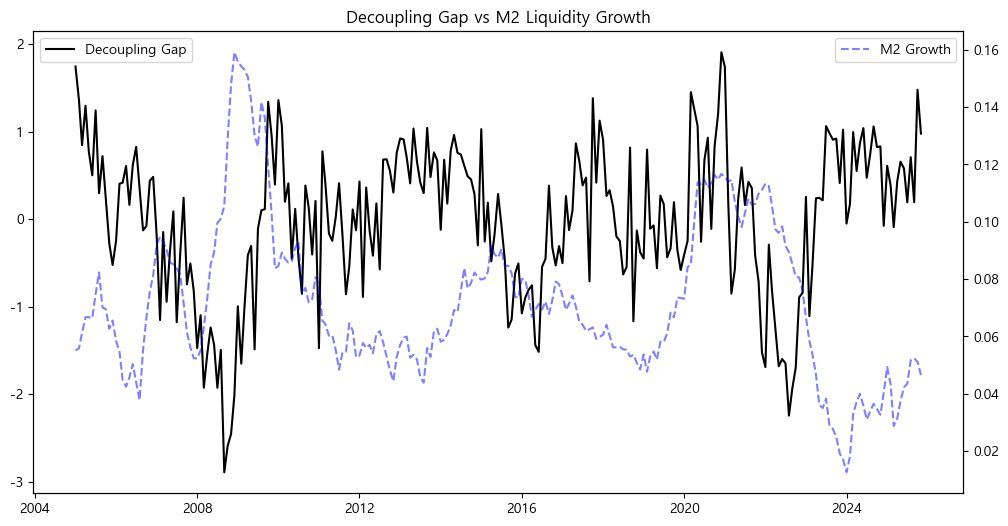

In [51]:
# 시각화 
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df.index, df['gap'], color='black', label='Decoupling Gap')
ax2 = ax1.twinx()
ax2.plot(df.index, df['m2_growth'], color='blue', linestyle='--', alpha=0.5, label='M2 Growth')
ax1.set_title('Decoupling Gap vs M2 Liquidity Growth')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

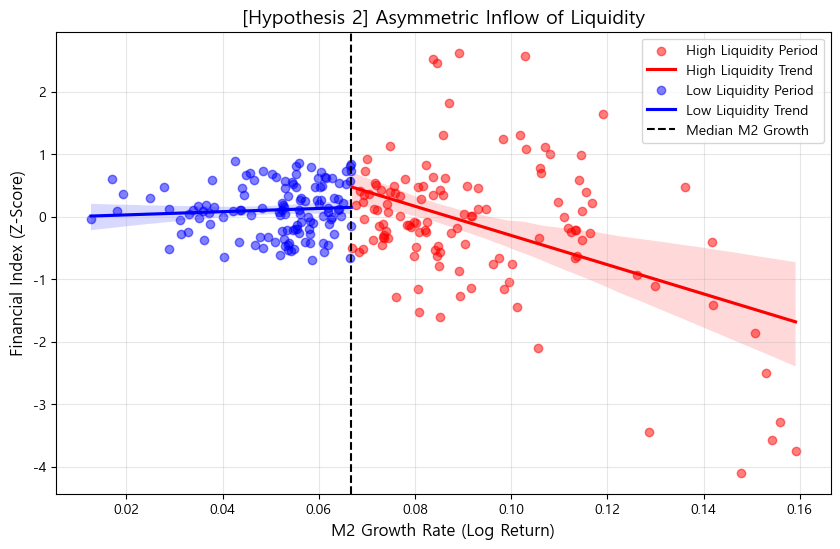

In [52]:
# 2. 시각화 (산점도 + 회귀선)
plt.figure(figsize=(10, 6))

# 고유동성 구간 (빨간색)
sns.regplot(x=high_liq['m2_growth'], y=high_liq['fin_index'], 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red', 'label':'High Liquidity Trend'}, 
            color='red', label='High Liquidity Period')

# 저유동성 구간 (파란색)
sns.regplot(x=low_liq['m2_growth'], y=low_liq['fin_index'], 
            scatter_kws={'alpha':0.5}, line_kws={'color':'blue', 'label':'Low Liquidity Trend'}, 
            color='blue', label='Low Liquidity Period')

plt.title('[Hypothesis 2] Asymmetric Inflow of Liquidity', fontsize=14)
plt.xlabel('M2 Growth Rate (Log Return)', fontsize=12)
plt.ylabel('Financial Index (Z-Score)', fontsize=12)
plt.axvline(median_val, color='black', linestyle='--', label='Median M2 Growth')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()